# Gaussian Mixture Model - EM algorithm for aproximating the parameters of the generative  process.

### Andrei Gabriel Popescu 
#### IA-B

### Setup

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import seaborn as sns
sns.set()

# Set random seed to a fixed value
np.random.seed(42)

### Decision boundary plot (helper function)

In [92]:
def plot_decision_boundary(classifier: GMM or KMeans, X: np.ndarray, y: np.ndarray, N: int = 10 , ax = None ):
    '''
        Utility function to plot decision boundary and scatter plot of data
        - N: int - size of the mesh grid
        - X: np.ndarray - input data
        - y: np.ndarray - predicted cluster membership
    '''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))
    
    classes = len(np.unique(y))
    
    # Check what methods are available
    if hasattr(classifier, "predict"):
        zz = np.array([
            classifier.predict(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy))
        ])
        
    elif hasattr(classifier, "predict_probabilities"):
        zz = np.array([
            classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy))
        ])
    else :
        zz = np.array([
            classifier(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy))
        ])
            
    # Reshape result and plot
    Z = zz.reshape(xx.shape)
    
    
    # Get current axis and plot
    if ax is None:
        ax = plt.gca()
        
    ax.contourf(xx, yy, Z, classes-1, cmap='viridis', alpha=.2)
    ax.contour(xx, yy, Z,  classes-1, cmap='viridis')
    ax.scatter(X[:,0],X[:,1],c = classifier.predict(X), cmap = 'viridis')
    
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')

In [93]:
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

### Reading and parsing data

In [94]:
gmm_samples_path = "./GMM.in"

In [95]:
def load_data() -> np.ndarray:
    data = []
    with open(gmm_samples_path) as f:
        for line in f:
            [x, y] = line.split(" ")
            x = float(x)
            y = float(y)
            data.append([x, y])
    
    return np.array(data)

### Custom GMM class that sub-implements the EM algorithm 

In [96]:
class GMM:
    def __init__(self, num_components: int = 4, iter_limit: int = 100, eps: float = 0.001):
        self.num_components = num_components
        self.iter_limit = iter_limit
        self.eps = eps
        
        # Inner parameters
        self.means = None
        self.covariances = None
        self.log_likelihoods = None
    
    def fit(self, X: np.ndarray) -> None:
        n, d = X.shape  # n = datapoints, d = features
        k = self.num_components  # K number of clusters

        # Randomly initialize the starting means
        mu = X[np.random.choice(n, k, replace = False)]

        # Initialize a covariance matrix for each gaussian
        Sigma = [np.eye(d)] * k

        # Initialize the probability for each gaussian pi
        pi = np.array([1 / k] * k)

        # Initialize responsibility matrix: n points for each gaussian
        W = np.zeros((n,k))

        # Initialize list of log-likelihoods
        log_likelihoods = []
        
        # Lambda function for gaussian pdf
        P = lambda m, s: multivariate_normal.pdf(X, mean = m, cov = s)
            
        while len(log_likelihoods) < self.iter_limit:
            # E step
            
            # Nominator of responsibilities: j is the j-th gaussian
            for j in range(k):
                W[:, j] = pi[j] * P(mu[j], Sigma[j])

            # Log likelihood computation (same as nominator of responsibilities)    
            l = np.sum(np.log(np.sum(W, axis = 1)))

            # Store log likelihood in list
            log_likelihoods.append(l)

            # Compute W matrix by dividing by denominator (the sum along j) 
            W = (W.T / W.sum(axis = 1)).T

            # Sum of w^i entries along j (used for parameter updates)
            # These are the soft weighted number of datapoints belonging to each gaussian
            W_s = np.sum(W, axis = 0)

            # M step
            
            for j in range(k):

                # Update means
                mu[j] = (1. / W_s[j]) * np.sum(W[:, j] * X.T, axis = 1).T 

                # Update covariances
                Sigma[j] = ((W[:,j] * ((X - mu[j]).T)) @ (X - mu[j])) / W_s[j]

                # Update probabilities of each gaussian
                pi[j] = W_s[j] / n

            # Ceck for convergence
            if len(log_likelihoods) < 2: continue
            if np.abs(l - log_likelihoods[-2]) < self.eps: break

        self.means = mu
        self.covariances = Sigma
        self.log_likelihoods = log_likelihoods
        
    def predict_probabilities(self, x0: np.ndarray) -> np.ndarray:
        probs = np.array([ 
            multivariate_normal.pdf(x0, mean = self.means[j], cov = self.covariances[j]) \
            for j in range(self.num_components) 
        ])
        
        return probs
    
    def predict(self, x0: np.ndarray) -> np.ndarray:
        probs = np.array([ 
            multivariate_normal.pdf(x0, mean = self.means[j], cov = self.covariances[j]) \
            for j in range(self.num_components) 
        ])
        
        return np.argmax(probs, axis = 0)

In [97]:
d = load_data()

### Compare the results with k-means

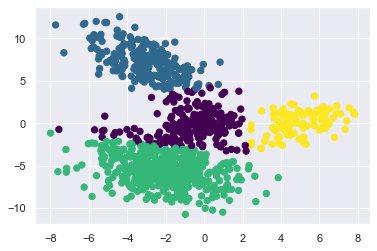

In [120]:
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(d).predict(d)
plt.scatter(d[:, 0], d[:, 1], c=labels, s=40, cmap='viridis')

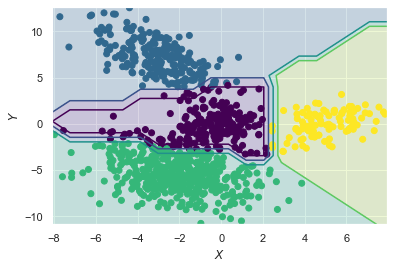

In [121]:
plot_decision_boundary(classifier=kmeans, X=d, y=labels, N=20 , ax=None)

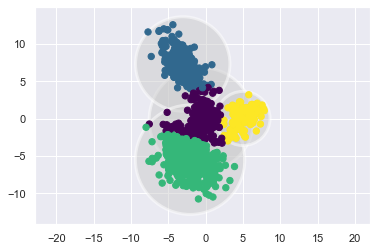

In [122]:
plot_kmeans(kmeans=kmeans, X=d)

In [150]:
for i in range(4):
    print('mu: {}'.format(kmeans.cluster_centers_[i][0]))
    print('mu: {}'.format(kmeans.cluster_centers_[i][1]))
    print("====")


mu: -0.5833008474576271
mu: -0.16954237288135598
====
mu: -3.0782792792792795
mu: 7.315166666666666
====
mu: -2.0899144144144146
mu: -5.513538288288288
====
mu: 4.99388775510204
mu: 0.01456122448979591
====


In [132]:
gmm = GMM(eps=1e-10)
gmm.fit(d)

In [146]:
for i in range(4):
    print('mu: {} : {}'.format(gmm.means[i][0], gmm.covariances[i][0]))
    print('mu: {} : {}'.format(gmm.means[i][1], gmm.covariances[i][1]))
    print("======")


mu: -0.09831876520254526 : [0.87383929 0.10019815]
mu: -0.06227261223149287 : [0.10019815 1.12119623]
mu: 4.935844280802135 : [1.82354588 0.85741221]
mu: -0.027327217117688433 : [0.85741221 1.88896328]
mu: -2.8582685710262807 : [ 2.68180797 -2.43698632]
mu: 6.934531707332293 : [-2.43698632  4.84390041]
mu: -2.1024780863554295 : [ 3.68877085 -1.10620934]
mu: -5.12426265039546 : [-1.10620934  4.06044983]


In [59]:
# Label the points 
y = gmm.predict(x0 = d)

Text(0.5, 1.0, 'EM-Gausian Mixture Model')

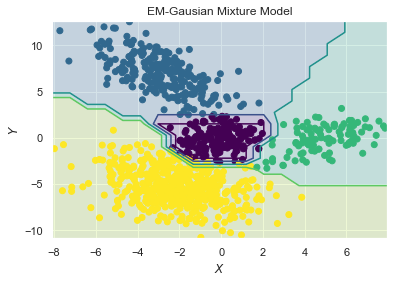

In [60]:
plot_decision_boundary(classifier=gmm, X=d, y=y, N=20 , ax=None)
plt.title('EM-Gausian Mixture Model')

Text(0.5, 1.0, 'Log likelihood')

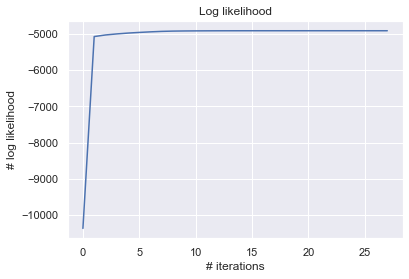

In [61]:
plt.plot(gmm.log_likelihoods)
plt.xlabel('# iterations')
plt.ylabel('# log likelihood')
plt.title('Log likelihood')